In [1]:
import sys
import numpy as np
import pickle
from mne_bids import BIDSPath, read_raw_bids
from bids import BIDSLayout
from util.io.coherence import *
from util.io.iter_BIDSPaths import *
from mne_connectivity import spectral_connectivity_time, check_indices
from mne.simulation import simulate_raw

In [2]:
from util.io.coherence import *

In [3]:
SUB = '31'
RUN = '1'
TASK = 'pitch'
FPATH = '/project2/hcn1/pitch_tracking/data/bids/derivatives/preprocessing/sub-31/sub-31_task-pitch_run-1_res-hi_desc-clean_epo.fif.gz'

BIDS_ROOT = '../data/bids'
FIGS_ROOT = '../figs'

DERIV_ROOT = '../data/bids/derivatives'
METHOD = 'coh'
FS = 5000
RAW_TMIN = -0.2
RAW_TMAX = 0.5
TMIN = 0
TMAX = 0.25
N_CHANS = 62
CONDS = ['50', '100', '150', '200', '250']
FREQS = [50, 100, 150, 200, 250]

In [4]:
# Load epoched data
epochs = mne.read_epochs(FPATH, preload = True)
events = epochs.events
n_epochs = len(events)

Reading /project2/hcn1/pitch_tracking/data/bids/derivatives/preprocessing/sub-31/sub-31_task-pitch_run-1_res-hi_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -200.00 ...     250.00 ms
        0 CTF compensation matrices available
Reading /project2/hcn1/pitch_tracking/data/bids/derivatives/preprocessing/sub-31/sub-31_task-pitch_run-1_res-hi_desc-clean_epo.fif-1.gz ...
    Found the data of interest:
        t =    -200.00 ...     250.00 ms
        0 CTF compensation matrices available
Not setting metadata
4801 matching events found
No baseline correction applied
0 projection items activated


In [5]:
# Use a different sub for generating stim channels if sub has bad Aux channel
STIM_SUB, STIM_RUN = get_stim_sub(SUB, RUN)

In [6]:
def create_stim_epochs_object(stim_epochs_array, events, CONDS, FS, RAW_TMIN):
    info = mne.create_info(ch_names = CONDS,
                           ch_types = ['eeg'] * 5,
                           sfreq = FS)

    # Manually add channel info to match original data to stop mne from shouting at us, very hacky
#     info['custom_ref_applied'] = True
#     info['description'] = 'Anonymized using a time shift to preserve age at acquisition'
#     info['experimenter'] = 'mne_anonymize'
#     info['highpass'] = 30.0
#     info['line_freq'] = 60.0
#     info['lowpass'] = 270.0
    event_id = {'100': 10001, '150': 10002, '200': 10003, '250': 10004, '50': 10005}

    # Manually add info that is passed in through mne.EpochsArray instead of in the info dict, also very hacky
    baseline = (-0.20000000298023224, 0.0)

    # Create Epochs object
    simulated_epochs = mne.EpochsArray(stim_epochs_array, 
                                       info, 
                                       events = events, 
                                       tmin = RAW_TMIN, 
                                       event_id = event_id, 
                                       baseline = baseline)
    return(simulated_epochs)

In [32]:
# Create epochs from raw data to create simulated stim channels
raw_epochs = get_raw_epochs(BIDS_ROOT, STIM_SUB, TASK, STIM_RUN)
stim_epochs_array = create_stim_epochs_array(raw_epochs, n_epochs, CONDS)
simulated_epochs = create_stim_epochs_object(stim_epochs_array, events, CONDS, FS, RAW_TMIN)

Loading data for 1180 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 1234 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 1216 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 1219 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 1151 events and 3501 original time points ...
0 bad epochs dropped


In [8]:
# Crop data so both epoch objects have same windowing
simulated_epochs = simulated_epochs.crop(tmin = TMIN, tmax = TMAX)
epochs = epochs.crop(tmin = TMIN)

In [10]:
# # Compute coherence
fmin, fmax = get_fmin_and_fmax(CONDS)
coh_df = pd.DataFrame()
indices = get_coh_indices(N_CHANS)
indices = check_indices(indices)
# indices = ([0, 0, 0, 0, 0], [1, 2, 3, 4, 5])

# Compute coherence over each condition
for cond in CONDS: 
    cond_epochs = combined_epochs[cond]
    
    # Index over n epochs at a time
    n = 10
    start_indexes = list(range(n, n_epochs, n))
    start_indexes.insert(0, 0)
    end_indexes = list(range(n, n_epochs, n))
    n_epochs = cond_epochs.__len__()
    end_indexes.append(n_epochs)
    
    for start, end in zip(start_indexes, end_indexes):
        print(f'start: {start}, end: {end}')
        
        # Compute coherence over 100 epochs
        cond_epochs_slice = cond_epochs[start:end]
        con = spectral_connectivity_time( # of shape (n_epochs, n_nodes, n_nodes, n_freqs)
            cond_epochs_slice,
            freqs = FREQS,
#             indices = indices,
            method = 'coh', 
            sfreq = FS, 
            n_jobs = 1)
        break
        
    # save_file_name = 'subj-' + SUB + '_task-pitch_cond-' + cond + '_coh_by_epoch.pkl'
    # save_dir = '/project2/hcn1/pitch_tracking/data/bids/derivatives/coherence'
    # save_path = save_file_name + save_dir
    # with open(save_path, 'wb') as file:
    #     pickle.dump(std1, save_path)
    #     print(f'Object successfully saved to "{save_path}"')
    break



start: 0, end: 10
Adding metadata with 3 columns
Connectivity computation...


  0%|          |  : 0/1953 [00:00<?,       ?it/s]

In [16]:
np.shape(epochs.get_data())

(4801, 67, 1251)

In [17]:
np.shape(simulated_epochs.get_data())

(4801, 5, 1251)

In [18]:
import matplotlib.pyplot 

In [27]:
np.shape()

(5, 3501)

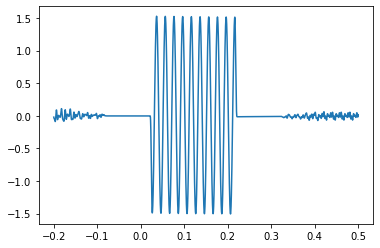

In [24]:
n_samples = 3501
t = np.linspace(RAW_TMIN, RAW_TMAX, n_samples, endpoint = False)
plt.plot(t, stim_epochs_array[0, 0, :])

In [26]:
np.shape(stim_epochs_array)

(4801, 5, 3501)